In [4]:
import json
import pandas as pd

# Load tweets
social_networks = ["pinterest", "facebook", "instagram", "tumblr", "linkedin"]
tweets_dict = {network: [] for network in social_networks}
for network in social_networks:
    with open('./collections/' + network + '.json', mode='r') as f:
        network_tweets = []
        for line in f:
            network_tweets.append(json.loads(line))
    for tweet in network_tweets:
        tweets_dict[network].append(tweet)


In [10]:
len(tweets_dict['tumblr'])

144180

In [13]:
# Create DataFrame
arr = []
for network in tweets_dict:
    for i, tweet in enumerate(tweets_dict[network]):
        text = tweet['text']
        is_rt = text.startswith("RT")
        row = {'user': tweet['user']['id_str'],
               'text': text,
               'network': network,
               'is_rt': is_rt}
        arr.append(row)

df = pd.DataFrame(arr)

In [15]:
by_network = df.groupby(by='network')

In [42]:
 
for name,group in by_network:
    print(name, len(group),len(group[group['is_rt']==False].index),
          len(group[group['is_rt']==True].index), len(np.unique(group['user'])))

facebook 40995 10191 30804 482
instagram 37194 8026 29168 500
linkedin 60042 24724 35318 823
pinterest 301050 47122 253928 841
tumblr 144180 60244 83936 877


In [22]:
by_is_rt = df.groupby(by='is_rt')

In [25]:
import numpy as np

In [44]:
# Print num of distinct users per network with not RT
for is_rt, group in by_is_rt:
    if not is_rt:
        print('###### No RT #######')
        for network in social_networks:
            totsl_num_users = len(np.unique(df[df['network']==network]['user']))
            num_users = len(np.unique(group[group['network']==network]['user']))
            print(network, num_users, 100*num_users/totsl_num_users)
    else:
        print('###### Only RT #######')
        for network in social_networks:
            totsl_num_users = len(np.unique(df[df['network']==network]['user']))
            num_users = len(np.unique(group[group['network']==network]['user']))
            print(network, num_users, 100*num_users/totsl_num_users)

###### No RT #######
pinterest 763 90.72532699167658
facebook 309 64.10788381742739
instagram 405 81.0
tumblr 699 79.70353477765109
linkedin 751 91.25151883353584
###### Only RT #######
pinterest 646 76.81331747919144
facebook 407 84.43983402489627
instagram 338 67.6
tumblr 791 90.19384264538198
linkedin 471 57.22964763061968


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x431793518>]],
      dtype=object)

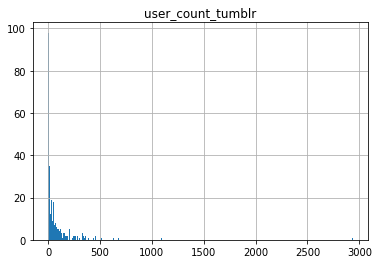

In [54]:
# Plot hist of number of tweets per users for each network - No RT
for network, data in by_network:
    no_rt = data[data['is_rt']==False]
    arr_count = [] 
    for user, user_data in no_rt.groupby(by='user'):
        user_count = user_data.shape[0]
        row = {'user':user,'user_count_'+network : user_count}
        arr_count.append(row)
    df_users_counts = pd.DataFrame(arr_count)
    df_users_counts.hist(column='user_count_'+network, bins=1000)
        

In [61]:
# Avg num of tweets per user for each network - No RT
print("Network\tAvg_num_tweets_for_user (SD)\t max")
for network, data in by_network:
    no_rt = data[data['is_rt']==False]
    arr_count = [] 
    for user, user_data in no_rt.groupby(by='user'):
        arr_count.append(user_data.shape[0])
    print('{}\t{}({})\t{}'.format(network,np.mean(arr_count),np.std(arr_count),np.max(arr_count)))
    print(np.sort(arr_count)[-5:])

Network	Avg_num_tweets_for_user (SD)	 max
facebook	32.980582524271846(78.08227101531983)	720
[270 419 481 676 720]
instagram	19.817283950617284(55.945883883332044)	555
[233 339 375 544 555]
linkedin	32.92143808255659(81.62559751024158)	1526
[ 421  461  508  539 1526]
pinterest	61.758846657929226(103.83094201018416)	1004
[ 615  739  924  960 1004]
tumblr	86.1859799713877(167.4541161188806)	2936
[ 751  815 1090 1230 2936]


In [70]:
# Sentiment with nltk

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

for network, data in by_network:
    print(network)
    no_rt = data[data['is_rt']==False]
    polarity_dict = {'neg': [], 'neu': [], 'pos':[], 'compound':[]}
    for i,tweet in no_rt.iterrows():
        polarity = sid.polarity_scores(tweet['text'])
        polarity_dict['neg'].append(polarity['neg'])
        polarity_dict['neu'].append(polarity['neu'])
        polarity_dict['pos'].append(polarity['pos'])
        polarity_dict['compound'].append(polarity['compound'])
    print ('neg:{}, neu:{}, pos:{}, compound:{}'.format(np.mean(polarity_dict['neg']),
                                                        np.mean(polarity_dict['neu']),
                                                        np.mean(polarity_dict['pos']),
                                                        np.mean(polarity_dict['compound'])))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/benl/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
facebook
neg:0.06403895594151701, neu:0.8097308409380827, pos:0.12623304876852126, compound:0.09981660288489844
instagram
neg:0.05940356341888862, neu:0.7905392474458012, pos:0.14993147271368054, compound:0.14671014203837526
linkedin
neg:0.04198365960200615, neu:0.8340328021355767, pos:0.12398167772205143, compound:0.15641838699239607
pinterest
neg:0.06529886252705742, neu:0.8122298289546284, pos:0.12247082042358133, compound:0.10080782437078223
tumblr
neg:0.07744006042095479, neu:0.77345418630901, pos:0.14894195272558264, compound:0.11238903293274019


In [71]:
# Sentiment with flair

import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

for network, data in by_network:
    print(network)
    no_rt = data[data['is_rt']==False]
    polarity_dict = {'neg': [], 'neu': [], 'pos':[], 'compound':[]}
    for i,tweet in no_rt.iterrows():
        ben = 4
s = flair.data.Sentence(tweet['text'])
flair_sentiment.predict(s)
total_sentiment = s.labels
#         polarity_dict['neg'].append(polarity['neg'])
#         polarity_dict['neu'].append(polarity['neu'])
#         polarity_dict['pos'].append(polarity['pos'])
#         polarity_dict['compound'].append(polarity['compound'])
#     print ('neg:{}, neu:{}, pos:{}, compound:{}'.format(np.mean(polarity_dict['neg']),
#                                                         np.mean(polarity_dict['neu']),
#                                                         np.mean(polarity_dict['pos']),
#                                                         np.mean(polarity_dict['compound'])))

2019-07-07 17:26:48,067 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/models-v0.4/TEXT-CLASSIFICATION_imdb/imdb.pt not found in cache, downloading to /var/folders/q7/926ntdp17c5_68cq17gzm7c80000gn/T/tmp2kfzeogr


 43%|████▎     | 1190022144/2794252905 [03:24<04:16, 6264333.05B/s]

KeyboardInterrupt: 

In [72]:
for is_rt, group in by_is_rt:
    if not is_rt:
        group.to_csv('./no_rt_data.csv')